# Trabalho Circuitos II - Análise de Circuitos no Tempo

In [63]:
from sympy.abc import s, t
from sympy import init_printing
from sympy.matrices import Matrix
from sympy.integrals import  inverse_laplace_transform
import numpy as np
import sympy as sp
import pandas as pd

#print do sympy:
init_printing()
#link do arquivo csv no github
url = 'https://raw.githubusercontent.com/V-kr0pt/Trabalho_Circuitos_II/master/circuito.csv'
url2 = 'https://raw.githubusercontent.com/V-kr0pt/Trabalho_Circuitos_II/master/circuito_dos_menino.csv'

#tornando o arquivo csv um dataframe
circuito = pd.read_csv('circuito_dos_menino.csv', sep=',')

#retirando última coluna não existente
circuito.dropna(axis=1, inplace=True)

circuito

,Ramo,nó saída,nó chegada,R(Ohm),L(H),I0(A),C(F),V0(V),Vind(V),Iind(A)
0,1,1,2,4,1,0,0.0,0,12,0
1,2,1,2,2,0,0,0.0,0,0,0
2,3,1,2,0,0,0,0.5,12,0,0


## Passos para matriz A

### Dimensões da matriz
Sabemos que a matriz tem dimensões nxb, aonde n representa a quantidade de nós e b a quantidade de ramos (*branchs*)  

In [64]:
# - Quantos nós e quantos ramos existem no circuito?

#criando um dataframe que possui somente os nós
nos = circuito[['nó saída', 'nó chegada']]

#sabemos que a quantidade de nós vai ser dada pelo máximo número encontrado na tabela "nos" criada
quantidade_de_nos = nos.values.max()

#a quantidade de ramos é dada pela quantidade de linhas que possuimos na tabela.
quantidade_de_ramos = circuito.shape[0] 

#a matriz de incidencia completa terá dimensões quantidade_de_nos x quantidade_de_ramos
incidencia_completa = sp.zeros(quantidade_de_nos, quantidade_de_ramos) #matriz de zeros


Ainda sabemos que como os nossos ramos são grafos orientados, a matriz de incidência terá em uma coluna somente 2 linhas com valores diferente de 0, uma com valor **1** (linha referente ao nó de saída) e outra com valor **-1** (linha referente ao nó de chegada) 

In [65]:
#Além disso terá 1 quando a corrente tiver saindo do nó e -1 quando estiver chegando
for ramo in range(quantidade_de_ramos): 
    #contando o nó a partir do zero
    no_de_saida = nos['nó saída'][ramo] - 1 
    no_de_chegada =  nos['nó chegada'][ramo] - 1

    incidencia_completa[no_de_saida,ramo] = 1
    incidencia_completa[no_de_chegada, ramo] = -1

incidencia_completa

⎡1   1   1 ⎤
⎢          ⎥
⎣-1  -1  -1⎦

Porém, sabemos que a matriz de incidência é linearmente dependente, então não precisamos usar todas as linhas da matriz, podemos alcançar todos os resultados desejados com a matriz de incidência reduzida (retirando a última linha)

In [66]:
#incidencia_reduzida será a matriz de incidência reduzida. Iremos retirar a última linha da incidencia_completa
incidencia_reduzida = incidencia_completa[:-1,:]
incidencia_reduzida

[1  1  1]

In [67]:
#a transpota da matriz de incidência reduzida:
incidencia_reduzida.T

⎡1⎤
⎢ ⎥
⎢1⎥
⎢ ⎥
⎣1⎦

## Passos para a matriz Yb

Vamos receber as impedâncias dos componentes através do arquivo de texto, então é interessante fazer uma tabela com a impedância resultante de cada ramo 

In [68]:
# Passos para conseguir a matriz Y:

#Cálculo das impedâncias
#Resistivas:
circuito['impedancias'] = circuito['R(Ohm)']  

#indutivas
circuito['impedancias'] = circuito['impedancias'] + s * circuito['L(H)']

#capacitivas
imp_capacitiva = 1/(s * circuito['C(F)'])

#zerando a transformada de laplace para os ramos com capacitância nula
imp_capacitiva .loc[circuito['C(F)'] == 0] = 0
circuito['impedancias'] = circuito['impedancias'] + imp_capacitiva 

circuito['impedancias']

0    s + 4
1        2
2    2.0/s
Name: impedancias, dtype: object

Como estamos utilizando o método dos nós vamos precisar definir uma matriz diagonal de admitâncias, por tanto podemo aplicar a função inversa nas impedâncias para termos uma tabela dos valores de admitância  

In [69]:
# A tabela das admitâncias:
Y_tab = 1/circuito['impedancias']
Y_list = list(Y_tab)
Y_list

In [70]:
# Matriz Diagonal das Admitâncias:
Yb = sp.Matrix.diag(Y_list) 
Yb 

⎡  1              ⎤
⎢─────   0     0  ⎥
⎢s + 4            ⎥
⎢                 ⎥
⎢  0    1/2    0  ⎥
⎢                 ⎥
⎣  0     0   0.5⋅s⎦

## Fontes Independentes  

### Fontes de tensão independentes 

In [71]:
Vs_tab = circuito['Vind(V)'] + circuito['L(H)'] * circuito['I0(A)'] + circuito['V0(V)']  #adicionei a última parcela, correto?

#Transformada de Laplace
Vs_tab = Vs_tab/s
Vs_list = list(Vs_tab)
Vs_list

In [72]:
# Matriz das Fontes Indp. de Tensão
Vs = Matrix(Vs_list)
Vs

⎡12⎤
⎢──⎥
⎢s ⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎢12⎥
⎢──⎥
⎣s ⎦

### Fontes de corrente indepentes 

In [73]:
Js_tab = circuito['Iind(A)']  
Js_tab

0    0
1    0
2    0
Name: Iind(A), dtype: int64

In [74]:
# Verticalizando o vetor:  Não sei se é necessário
Js = Matrix(Js_tab)
Js

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

In [75]:
# Matriz Admitância do Nó:

# Incidência Reduzida * Matriz das Admitâncias Diagonalizada * Incidência  Reduzida Transposta
Yn = incidencia_reduzida * Yb * incidencia_reduzida.T  

Yn

⎡        1     1  ⎤
⎢0.5⋅s + ─ + ─────⎥
⎣        2   s + 4⎦

## Calculando Is (corrente de nó)

In [76]:
Is = incidencia_reduzida * Yb * Vs - incidencia_reduzida * Js
Is

⎡          12   ⎤
⎢6.0 + ─────────⎥
⎣      s⋅(s + 4)⎦

### Calculando a tensão de nó

In [77]:
Yn.inv() 
Is
#a tensão de nó (simbolico):
E = Yn.inv() * Is 

E

⎡⎛          12   ⎞          ⎤
⎢⎜6.0 + ─────────⎟⋅(2⋅s + 8)⎥
⎢⎝      s⋅(s + 4)⎠          ⎥
⎢───────────────────────────⎥
⎢         2                 ⎥
⎣        s  + 5⋅s + 6       ⎦

### Tensão de ramo

In [78]:
V = incidencia_reduzida.T * E 
V.shape

### Corrente dos ramos

In [79]:
J = Js + Yb * V - Yb * Vs
J

⎡⎛          12   ⎞                      ⎤
⎢⎜6.0 + ─────────⎟⋅(2⋅s + 8)            ⎥
⎢⎝      s⋅(s + 4)⎠                 12   ⎥
⎢─────────────────────────── - ─────────⎥
⎢           ⎛ 2          ⎞     s⋅(s + 4)⎥
⎢   (s + 4)⋅⎝s  + 5⋅s + 6⎠              ⎥
⎢                                       ⎥
⎢      ⎛          12   ⎞                ⎥
⎢      ⎜6.0 + ─────────⎟⋅(2⋅s + 8)      ⎥
⎢      ⎝      s⋅(s + 4)⎠                ⎥
⎢      ───────────────────────────      ⎥
⎢              ⎛ 2          ⎞           ⎥
⎢            2⋅⎝s  + 5⋅s + 6⎠           ⎥
⎢                                       ⎥
⎢      ⎛          12   ⎞                ⎥
⎢0.5⋅s⋅⎜6.0 + ─────────⎟⋅(2⋅s + 8)      ⎥
⎢      ⎝      s⋅(s + 4)⎠                ⎥
⎢───────────────────────────────── - 6.0⎥
⎢            2                          ⎥
⎣           s  + 5⋅s + 6                ⎦

### Transformada Inversa

#### Obtemos problemas na transformada inversa, a biblioteca não é capaz de trazer a resposta da transformada inversa

A corrente do ramo 1 na frequência:


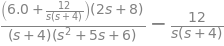

No tempo:


In [80]:
#a transformada inversa do ramo 1:
print("A corrente do ramo 1 na frequência:")
display(J[0])
print("No tempo:")
inverse_laplace_transform(J[0], s, t)

A corrente do ramo 1 na frequência:


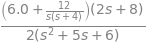

No tempo:


PolynomialError: RisingFactorial(_t + 1, 1.0) contains an element of the set of generators.

In [81]:
#a transformada inversa do ramo 0:
print("A corrente do ramo 1 na frequência:")
display(J[1])
print("No tempo:")
inverse_laplace_transform(J[1], s, t)

A corrente do ramo 3 na frequência:


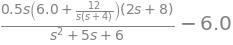

No tempo:


ValueError: gamma function pole

In [59]:
#a transformada inversa do ramo 0:
print("A corrente do ramo 3 na frequência:")
display(J[2])
print("No tempo:")
inverse_laplace_transform(J[2], s, t)

## Tabela de saída
Apresentando dados em uma tabela

In [88]:
#lista com os dados da tabela de saída
dados_de_saida_R = np.array([V, J])
dados_de_saida_N = np.array([E])
dados_de_saida_R

array([[[(6.0 + 12/(s*(s + 4)))*(2*s + 8)/(s**2 + 5*s + 6)],
        [(6.0 + 12/(s*(s + 4)))*(2*s + 8)/(s**2 + 5*s + 6)],
        [(6.0 + 12/(s*(s + 4)))*(2*s + 8)/(s**2 + 5*s + 6)]],

       [[(6.0 + 12/(s*(s + 4)))*(2*s + 8)/((s + 4)*(s**2 + 5*s + 6)) - 12/(s*(s + 4))],
        [(6.0 + 12/(s*(s + 4)))*(2*s + 8)/(2*(s**2 + 5*s + 6))],
        [0.5*s*(6.0 + 12/(s*(s + 4)))*(2*s + 8)/(s**2 + 5*s + 6) - 6.0]]],
      dtype=object)

In [84]:
label_saida_R = ['Tensão de ramo (Volts)', 'Corrente de ramo (Ampére)']
label_saida_N = ['Tensão de nó (Volts)']

In [26]:
saida_R =  dict(zip(label_saida_R,dados_de_saida_R))
saida_N = dict(zip(label_saida_N, dados_de_saida_N))
#dado_de_saida 

In [93]:
#df_saida = pd.DataFrame(saida_R, range(1,quantidade_de_ramos+1))
#df_saida_N = pd.DataFrame(saida_N, range(1,quantidade_de_nos))
#df_saida[label_saida_N]  = df_saida_N
#df_saida

In [ ]:
#df_saida_N = pd.DataFrame(saida_N, range(1,quantidade_de_nos))
#df_saida_N

In [ ]:
#df_saida[label_saida_N]  = df_saida_N
#df_saida